In [1]:
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices

In [2]:
import numpy as np

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
transactions = pd.read_csv('transactions_train.csv')

In [5]:
articles = pd.read_csv('articles.csv')

In [6]:
menswear_articles = articles[articles['department_name']=='Studio Collection']
merged = transactions[['article_id', 'price']].merge(
    menswear_articles[['article_id', 'product_type_name', 'colour_group_name', 'graphical_appearance_name']],
    on='article_id',
    how='inner'
)



feature_cols = ['product_type_name','colour_group_name','graphical_appearance_name']

X = merged[feature_cols]
y = merged["price"]


preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop='first'), feature_cols)
])


pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

pipeline.fit(X, y)
r2 = pipeline.score(X, y)
print(f"R² Score: {r2:.4f} — variance in price explained by features")

R² Score: 0.6342 — variance in price explained by features


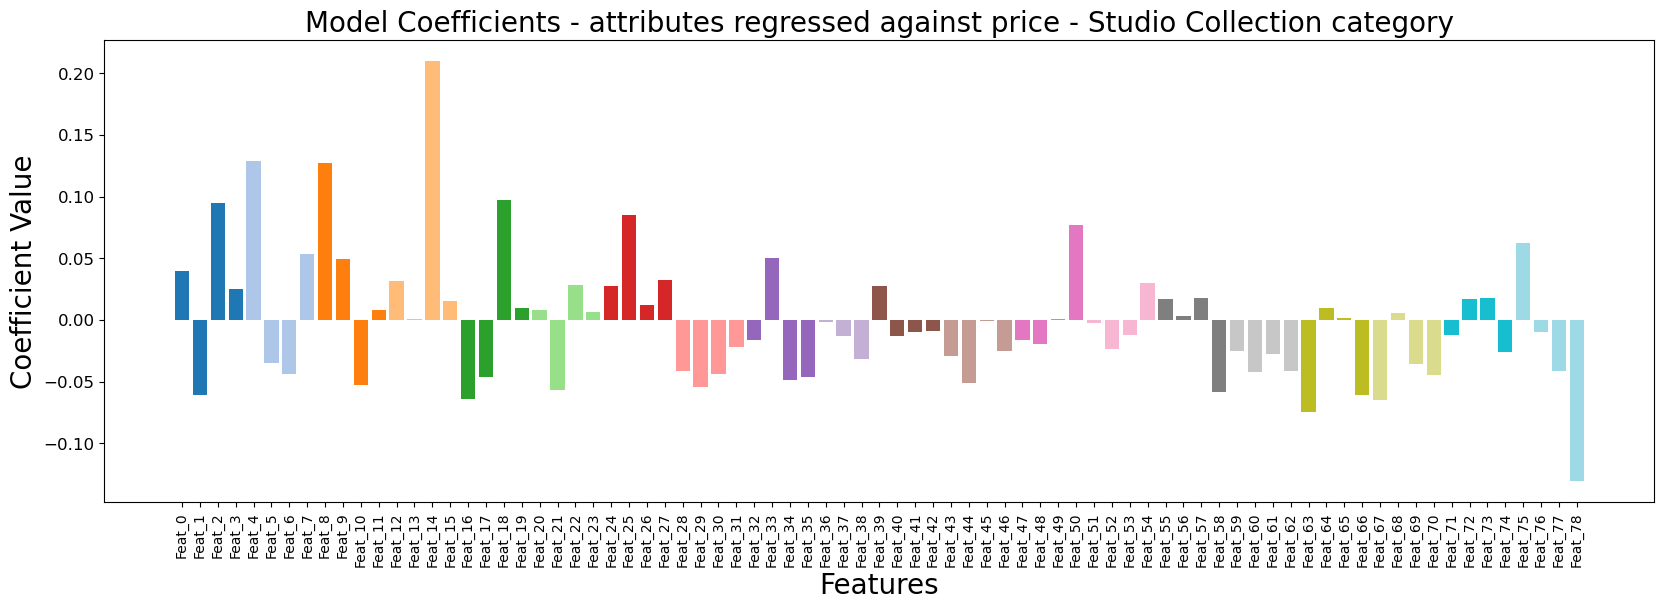

In [8]:
#pipeline.coef_# Get feature names after preprocessing
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Extract coefficients from the model (example: linear regression, logistic regression, etc.)
coefs = pipeline.named_steps['regressor'].coef_

# Pick a colormap with as many colours as features
colors = plt.cm.tab20(np.linspace(0, 1, len(coefs)))

fnames = ["Feat_" + str(i) for i in range(len(coefs))]


# Handle binary vs multi-class case
if coefs.ndim > 1:  
    # For multi-class (e.g., LogisticRegression with multiclass), pick one class or plot separately
    coefs = coefs[0]

# Plot coefficients as a bar plot
plt.figure(figsize=(20, 6))
plt.bar(range(len(coefs)), coefs,color=colors)
plt.xticks(range(len(coefs)), fnames, rotation=90)
plt.xlabel("Features",size=20)
plt.ylabel("Coefficient Value",size=20)
plt.yticks(fontsize=12)
plt.title("Model Coefficients - attributes regressed against price - Studio Collection category",size = 20)
plt.savefig('hnm_studiocollection.png',dpi=300)
plt.show()

In [ ]:
#R² Score: 0.3832 — variance in price explained by features - Kids dresses UW/NW
#R² Score: 0.3063 — variance in price explained by features - Kids Girl S&T
#R² Score: 0.6342 — variance in price explained by features - Studio collection

In [7]:
articles['article_id'] = articles['article_id'].astype(str)
transactions['article_id'] = transactions['article_id'].astype(str)

menswear_articles = articles[articles['department_name']=='Studio Collection']


merged = transactions[['article_id', 'price']].merge(
    menswear_articles[['article_id', 'product_type_name', 'colour_group_name', 'graphical_appearance_name']],
    on='article_id',
    how='inner'
)


merged.dropna(inplace=True)

formula = 'price ~ C(product_type_name) + C(colour_group_name) + C(graphical_appearance_name)'
y, X = dmatrices(formula, data=merged, return_type='dataframe')


model = sm.OLS(y, X).fit()
print(model.summary())

merged['pred_price'] = model.predict(X)
merged['resid'] = merged['price'] - merged['pred_price']
print("Mean residual:", merged['resid'].mean(), "Std dev residual:", merged['resid'].std())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     616.9
Date:                Mon, 01 Sep 2025   Prob (F-statistic):               0.00
Time:                        20:17:04   Log-Likelihood:                 52639.
No. Observations:               28189   AIC:                        -1.051e+05
Df Residuals:                   28109   BIC:                        -1.045e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [9]:
X = merged[feature_cols]
y = merged[["price"]]

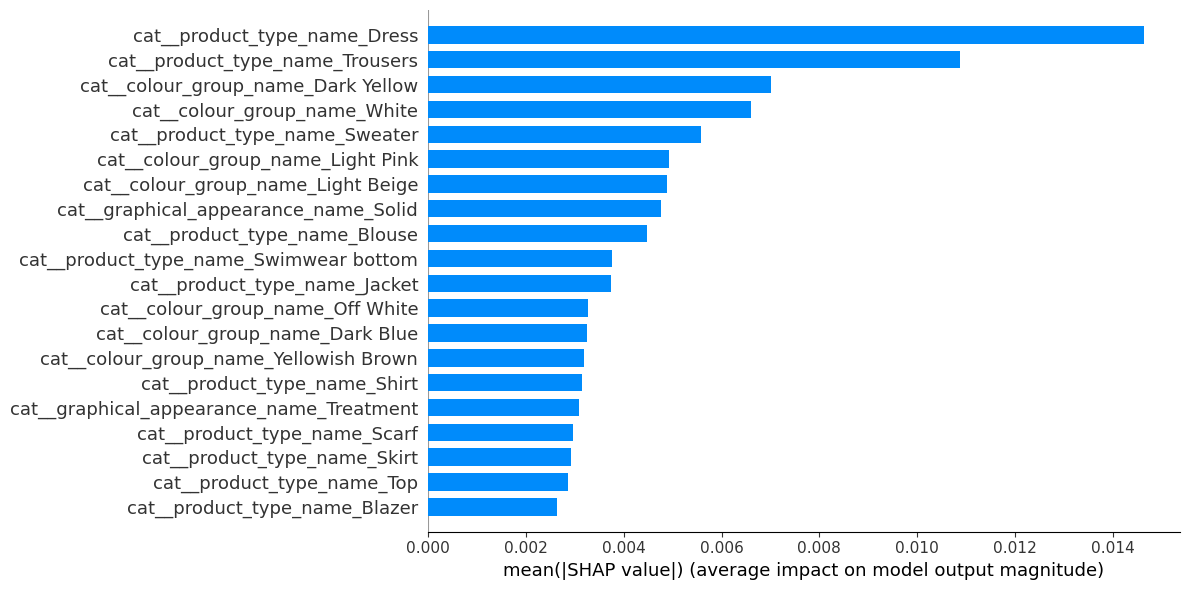

In [13]:
X_encoded_sparse = pipeline.named_steps['preprocessor'].transform(X)
#X_encoded_dense = X_encoded_sparse.toarray()  
X_encoded_dense = X_encoded_sparse

sample_idx = np.random.choice(X_encoded_dense.shape[0], size=500, replace=False)
X_sample = X_encoded_dense[sample_idx]

explainer = shap.Explainer(pipeline.named_steps['regressor'], X_encoded_dense)

shap_values = explainer(X_sample)

shap.summary_plot(
    shap_values,
    features=X_sample,
    feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out(),
    plot_type="bar",plot_size=[12,6]
)

#plt.gcf().set_size_inches(60,16)
#plt.show()
